# Proposed Model

In [ ]:
import torch
print(torch.cuda.is_available())  # True if GPU is available, False otherwise
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.get_device_name(0))  # Name of the first GPU
print(torch.cuda.current_device)
# print("hello world")

### Imports

In [13]:

import torch
import csv
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import InterpolationMode
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset,  Subset, random_split,  SubsetRandomSampler
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision import datasets, models
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import os
import seaborn as sns
import random
import torchvision.transforms.functional as F
from PIL import Image
from Datapreprocess import DualTransformDataset_2,Applytransform_inception, Applytransform_resnet, AugmentedImageFolder_inception, AugmentedImageFolder_resnet, DualTransformDataset
from sklearn.utils import shuffle
from torchinfo import summary
from torchvision.models import inception_v3
from torch.optim import AdamW  # Import AdamW
save_dir = "./DATASETS/ECD AUGMENTED_2 FULL"



### Data Preprocess and Splitting

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define save directories

train_dir = os.path.join(save_dir, "train")
val_dir = os.path.join(save_dir, "val")
test_dir = os.path.join(save_dir, "test")

# Ensure directories exist
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# Convert tensor to PIL image
to_pil = ToPILImage()

# Function to save images
def save_images(dataset, raw_dataset, split, augment=False):
    """
    Saves images to disk.

    Args:
        dataset: The dataset subset (train, val, or test).
        raw_dataset: The original dataset with class labels.
        split: "train", "val", or "test".
        augment: Apply augmentations if True (only for train).
    """
    save_path = os.path.join(save_dir, split)

    for idx in tqdm(range(len(dataset)), desc=f"Saving {split} set"):
        image, label = dataset[idx]  # Get image and label
        class_name = raw_dataset.classes[label]  # Get class name

        # Create class folder
        class_folder = os.path.join(save_path, class_name)
        os.makedirs(class_folder, exist_ok=True)
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        image = image.to(device)

        if augment:
            # Apply augmentations for train set
            aug_versions = {
                "original": image,
                "flipped": F.hflip(image),
                "grayscale": F.rgb_to_grayscale(image, num_output_channels=3),
                # "darkened": F.adjust_brightness(image, 0.6),
                # "whitened": F.adjust_brightness(image, 1.5),
            }

            # Save each augmentation
            for aug_name, aug_image in aug_versions.items():

                # if not isinstance(aug_image, torch.Tensor):
                #     aug_image = transforms.ToTensor()(aug_image)
                image = image.to("cpu")
                img_pil = to_pil(aug_image)
                img_pil.save(os.path.join(class_folder, f"{idx}_{aug_name}.jpg"))

        else:
         
            # # Only save the original image for val/test
            # if not isinstance(aug_image, torch.Tensor):
            #         aug_image = transforms.ToTensor()(aug_image)
            image = image.to("cpu")
            img_pil = to_pil(image)
            img_pil.save(os.path.join(class_folder, f"{idx}.jpg"))


Class Names: ['Appropriate', 'Inappropriate']
Appropriate class size: 833
Inappropriate class size: 834


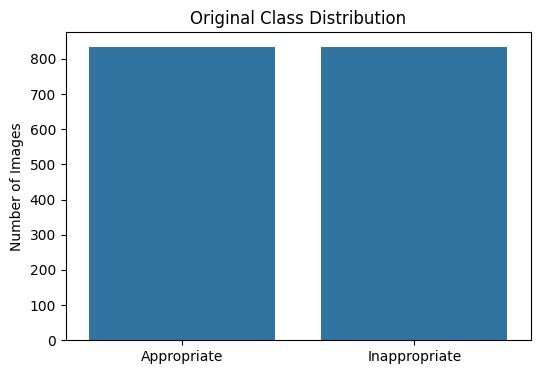

After Augmentation Train set size: 15666
Validation set size: 1119
Test set size: 1119
Balanced class distribution: 833 appropriate, 834 inappropriate


In [15]:

# Dataset path
# dataset_path = "./DATASETS/ECD DATASET CROPPED FULL"
dataset_path = "./DATASETS/cropped_images_800"
# dataset_path = "./train_45"

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for display
    transforms.ToTensor()
])
val_test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform_inception = transforms.Compose([
    transforms.Resize((299, 299), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path)
dataset_resnet = ImageFolder(dataset_path)
dataset_inception = ImageFolder(dataset_path)
dataset_visual = ImageFolder(dataset_path, transform=transform_visual)  # For showing images

# Extract class names
class_names = dataset_resnet.classes
print(f"Class Names: {class_names}")
# Separate images by class
appropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 0]
inappropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 1]

# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()



# # ALL INDICES
balanced_indices = list(range(len(dataset)))
balanced_indices = shuffle(balanced_indices)

# Define split sizes (e.g., 70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure total length matches

# train_idx, val_idx, test_idx = random_split(dataset_inception, [train_size, val_size, test_size])

# Split indices
train_idx = balanced_indices[:train_size]
val_idx = balanced_indices[train_size:train_size + val_size]
test_idx = balanced_indices[train_size + val_size:]

# # Create subsets for ResNet
# train_resnet = Subset(dataset, train_idx)
# val_resnet = Subset(dataset, val_idx)
# test_resnet = Subset(dataset, test_idx)


# # Create subsets for Inception (using the same indices)
# train_inception = Subset(dataset, train_idx)
# val_inception = Subset(dataset, val_idx)
# test_inception = Subset(dataset, test_idx)

# print(f"Before Augmentation Train set size: {len(train_resnet)}")
# print(f"Before Augmentation Train set size: {len(train_inception)}")

# # Save train set with augmentations
# save_images(train_resnet, dataset, "train", augment=True)

# # Save validation set without augmentation
# save_images(val_resnet, dataset, "val", augment=False)

# # Save test set without augmentation
# save_images(test_resnet, dataset, "test", augment=False)

# print(f"✅ All datasets saved in {save_dir}")

# train_resnet_aug = AugmentedImageFolder_resnet(train_resnet)
# train_inception_aug = AugmentedImageFolder_inception(train_inception)

# train_resnet_aug = Applytransform_resnet(train_resnet)
# train_inception_aug = Applytransform_inception(train_inception)


# # Apply transformations to val & test sets
# val_resnet_aug = Applytransform_resnet(val_resnet)
# test_resnet_aug = Applytransform_resnet(test_resnet)

# val_inception_aug = Applytransform_inception(val_inception)
# test_inception_aug = Applytransform_inception(test_inception)

# train_resnet_aug = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_resnet)
# val_resnet_aug = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_resnet)
# test_resnet_aug = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_resnet)

# train_inception_aug = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_inception)
# val_inception_aug = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_inception)
# test_inception_aug = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_inception)


# train_loader_resnet = DataLoader(train_resnet_aug, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
# val_loader_resnet = DataLoader(val_resnet_aug, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
# test_loader_resnet = DataLoader(test_resnet_aug, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)

# train_loader_inception = DataLoader(train_inception_aug, batch_size=32, shuffle=True, num_workers=4,pin_memory=True)
# val_loader_inception = DataLoader(val_inception_aug, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)
# test_loader_inception = DataLoader(test_inception_aug, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)


# train_subset = Subset(dataset, train_idx)
# val_subset = Subset(dataset, val_idx)
# test_subset = Subset(dataset, test_idx)

# train_dataset = DualTransformDataset(train_subset)
# val_dataset = DualTransformDataset(val_subset)
# test_dataset = DualTransformDataset(test_subset)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

train_dataset = DualTransformDataset_2(root=os.path.join(save_dir, "train"))

val_dataset = DualTransformDataset_2(root=os.path.join(save_dir, "val"))

test_dataset = DualTransformDataset_2(root=os.path.join(save_dir, "test"))
   






print(f"After Augmentation Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# print(f"After Augmentation Train set size: {len(train_inception_aug)}")
# print(f"Validation set size: {len(val_inception_aug)}")
# print(f"Test set size: {len(test_inception_aug)}")


# Check class distribution in the balanced dataset
print(f"Balanced class distribution: {len(appropriate_indices)} appropriate, {len(inappropriate_indices)} inappropriate")



## sample images

In [ ]:
# Get a batch of images and labels
data_iter = iter(train_loader_inception)
images, labels = next(data_iter)

# Print shape
print(f"Batch image shape: {images.shape}")  # Should be (32, 3, H, W)
print(f"Labels: {labels}")  # Should be tensor of size (32)


In [ ]:
import random

# Function to visualize multiple random augmented images
def visualize_random_augmentations(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Pick random indices to ensure variety
    random_indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Get a randomly chosen augmented image

        # Convert tensor to numpy
        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Reverse normalization for better visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean  # Undo normalization
        image_np = np.clip(image_np, 0, 1)  # Clip values to valid range

        axes[i].imshow(image_np)
        axes[i].axis("off")
        axes[i].set_title(f"Sample {idx}")

    plt.show()

# Test function
visualize_random_augmentations(AugmentedImageFolder_inception(dataset))


In [ ]:
# Sample and show images from both classes
def show_images(indices, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(random.sample(indices, num_images)):
        img, label = dataset_visual[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert to (H, W, C)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

show_images(appropriate_indices, "Sample: Appropriate Content")
show_images(inappropriate_indices, "Sample: Inappropriate Content")




In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display original vs. augmented images
def show_all_augmentations(train_dataset, raw_dataset, num_images=5):
    fig, axes = plt.subplots(5, num_images, figsize=(15, 15))  # 5 augmentations per image

    for i in range(num_images):
        index = random.randint(0, len(train_dataset) // 5 - 1)  # Select original images only
        base_idx = index * 5  # Index of the original image in the augmented dataset

        # Get original file path (before transformation)
        img_path, label_original = raw_dataset.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)
        mode_original = img_pil.mode  # Check mode

        # # ✅ Ensure image is in RGB mode
        # if mode_original != "RGB":
        #     img_pil = img_pil.convert("RGB")

        # Load images from train_dataset (already transformed)
        aug_names = ["Original", "Flipped", "Grayscale", "Darkened", "Whitened"]
        for j in range(5):  # 5 versions of each image
            img_aug, label_aug = train_dataset[base_idx + j]

            # Move tensor to CPU before converting to numpy
            img_aug_np = img_aug.cpu().permute(1, 2, 0).numpy()

            # Display the image
            axes[j, i].imshow(img_aug_np, cmap="gray" if j == 2 else None)
            axes[j, i].set_title(f"{aug_names[j]}\n{raw_dataset.classes[label_aug]}")
            axes[j, i].axis("off")

    plt.suptitle("Original vs. Augmented Images from Dataset")
    plt.show()

# Call function using the correct dataset
show_all_augmentations(train_resnet_aug, dataset)


In [ ]:
def denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 1, 3)
    std = torch.tensor(std).view(1, 1, 3)
    img = img * std + mean  # Undo normalization
    return img.clamp(0, 1)  # Keep values in range [0,1] for proper visualization

def show_all_augmentations(train_dataset, raw_dataset, num_images=5):
    fig, axes = plt.subplots(5, num_images, figsize=(15, 20))  # 5 augmentations per image

    aug_names = ["darkened", "flipped", "grayscale", "original", "whitened"]

    for i in range(num_images):
        index = random.randint(0, len(train_dataset) // 5 - 1)  # Select a random original image
        base_idx = index * 5  # Starting index of the 5 augmentations

        # Get original file path (before transformation)
        img_path, label_original = raw_dataset.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)

        # # Ensure image is in RGB mode
        if img_pil.mode != "RGB":
            img_pil = img_pil.convert("RGB")

        # Load images from the transformed dataset
        for j in range(5):  # Display all 5 augmentations
            img_aug, label_aug = train_dataset[base_idx + j]

            # Move tensor to CPU before converting to NumPy
          # With this:
            img_aug = denormalize(img_aug.permute(1, 2, 0))  # Undo normalization
            img_aug_np = img_aug.cpu().numpy()
                        # Apply grayscale colormap if displaying grayscale
            cmap = "gray" if aug_names[j] == "Grayscale" else None

            # Display the image
            axes[j, i].imshow(img_aug_np, cmap=cmap)
            axes[j, i].set_title(f"{aug_names[j]}\n{raw_dataset.classes[label_aug]}")
            axes[j, i].axis("off")

    plt.suptitle("Original vs. Augmented Images from Dataset")
    plt.show()

# Call function using the correct dataset
show_all_augmentations(train_dataset, dataset)


## Model Initialization

In [16]:

# # Define the model
# class FusionModel(nn.Module):
#     def __init__(self, num_classes):
#         super(FusionModel, self).__init__()
        
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
#         self.inception = models.inception_v3(aux_logits=False)
#         state_dict = pretrained_model.state_dict()
#         self.inception.load_state_dict(state_dict, strict=False)
        
#         # Step 1: Freeze All Layers Initially**
#         for param in self.resnet.parameters():
#             param.requires_grad = False
#         for param in self.inception.parameters():
#             param.requires_grad = False
        
#         # for param in self.resnet.fc.parameters():
#         #       param.requires_grad = True
#         # for param in self.inception.fc.parameters():
#         #       param.requires_grad = True    
              
#         self.resnet.fc = nn.Identity()
#         self.inception.fc = nn.Identity()
                   
#         # self.resnet.fc = None
#         # self.inception.fc = None
        
#         self.batch_norm = nn.BatchNorm1d(4096)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(4096, num_classes)
        
#     def forward(self, x_resnet, x_inception):
#         resnet_features = self.resnet(x_resnet)
       
#         inception_features = self.inception(x_inception)


#         if isinstance(inception_features, tuple):  # InceptionV3 returns a tuple
#             inception_features = inception_features[0]  # Take only the main output
#         fused_features = torch.cat((resnet_features, inception_features), dim=1)
#         fused_features = self.batch_norm(fused_features)
#         fused_features = self.relu(fused_features)
#         fused_features = self.dropout(fused_features)
#         output = torch.sigmoid(self.fc(fused_features))
#         output = self.fc(fused_features)  # No sigmoid here

#         return output


# class FusionModel(nn.Module):
#     def __init__(self, num_classes):
#         super(FusionModel, self).__init__()

#         # Load pretrained ResNet50 and freeze all layers
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         for param in self.resnet.parameters():
#             param.requires_grad = False
#         self.resnet.fc = nn.Identity()  # Remove ResNet FC layer
   
#         pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
#         self.inception_model = models.inception_v3(aux_logits=False)
#         self.inception_model.load_state_dict(pretrained_model.state_dict(), strict=False)


#         # Freeze all Inception layers
#         for param in self.inception_model.parameters():
#             param.requires_grad = False
            
#         self.inception_model.fc = nn.Identity()
#         self.inception_preprocess = nn.Sequential(
#             self.inception_model.Conv2d_1a_3x3,
#             self.inception_model.Conv2d_2a_3x3,
#             self.inception_model.Conv2d_2b_3x3,
#             self.inception_model.maxpool1,
#             self.inception_model.Conv2d_3b_1x1,
#             self.inception_model.Conv2d_4a_3x3,
#             self.inception_model.maxpool2,
#             self.inception_model.Mixed_5b,
#             self.inception_model.Mixed_5c,
#             self.inception_model.Mixed_5d,

#         )

#         # ✅ **Only keep high-level Inception layers**
#         self.inception_top_layers = nn.Sequential(
#             self.inception_model.Mixed_6a,
#             self.inception_model.Mixed_6b,
#             self.inception_model.Mixed_6c,
#             self.inception_model.Mixed_6d,
#             self.inception_model.Mixed_6e,
#             self.inception_model.Mixed_6d,
#             self.inception_model.Mixed_6e,
#             self.inception_model.Mixed_7a,
#             self.inception_model.Mixed_7b,
#             self.inception_model.Mixed_7c,
#             nn.AdaptiveAvgPool2d((1, 1)),  # Global avg pooling
#             # nn.Flatten()  # Flatten to 1D
#         )
        
       
#         # Fusion layer (concatenating 2048+2048 features)
#         self.fc = nn.Sequential(
#             nn.Linear(4096, 256),  # Compress to 512 features
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes),
#             nn.Sigmoid()
#         )

#     def forward(self, x_resnet, x_inception):
#         # Extract ResNet50 features
#         resnet_features = self.resnet(x_resnet)
#         # print(f"ResNet Features Shape: {resnet_features.shape}")  # Debugging Output


#         # ✅ **Process input through necessary Inception layers to get correct shape**
#         x_inception = self.inception_preprocess(x_inception)
#         # print(f"Inception Features Shape: {x_inception.shape}")  # Debugging Output

#         inception_features = self.inception_top_layers(x_inception).squeeze(-1).squeeze(-1)        
#         # print(f"Inception Features Shape: {inception_features.shape}")  # Debugging Output

#         # Concatenate features
        
#         fused_features = torch.cat((resnet_features,inception_features), dim=1)
      
#         output = self.fc(fused_features)

#         return output

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()

        # Load pre-trained ResNet50
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Remove the fully connected layer
        self.resnet.fc = nn.Identity()

    def forward(self, x):
        features = self.resnet(x)  # Extract features (2048-dim vector)
        return features
    
from torchvision.models.inception import Inception_V3_Weights

class InceptionV3Model(nn.Module):
    def __init__(self):
        super(InceptionV3Model, self).__init__()

        # Load pre-trained InceptionV3
        pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        self.inception = models.inception_v3(aux_logits=False)
        state_dict = pretrained_model.state_dict()
        self.inception.load_state_dict(state_dict, strict=False)

        # Remove the fully connected layer
        self.inception.fc = nn.Identity()

    def forward(self, x):
        features = self.inception(x)

        if isinstance(features, tuple):  # InceptionV3 sometimes returns a tuple
            features = features[0]

        return features  # Extracted feature vector (2048-dim)
    
class FusionModel(nn.Module):
    def __init__(self, num_classes=1):
        super(FusionModel, self).__init__()

        # Load feature extractors
        self.resnet_model = ResNet50Model()
        self.inception_model = InceptionV3Model()
        
        # ✅ Freeze all Inception and ResNet layers
        for param in self.inception_model.inception.parameters():
            param.requires_grad = False
        for param in self.resnet_model.resnet.parameters():
            param.requires_grad = False

        # ✅ Use correct reference for InceptionV3 layers
        self.inception_preprocess = nn.Sequential(
            self.inception_model.inception.Conv2d_1a_3x3,
            self.inception_model.inception.Conv2d_2a_3x3,
            self.inception_model.inception.Conv2d_2b_3x3,
            self.inception_model.inception.maxpool1,
            self.inception_model.inception.Conv2d_3b_1x1,
            self.inception_model.inception.Conv2d_4a_3x3,
            self.inception_model.inception.maxpool2,
            self.inception_model.inception.Mixed_5b,
            self.inception_model.inception.Mixed_5c,
            self.inception_model.inception.Mixed_5d,
            self.inception_model.inception.Mixed_6a,
            self.inception_model.inception.Mixed_6b,
            self.inception_model.inception.Mixed_6c,
        )

        # ✅ Extract only Mixed_6d to Mixed_7c
        self.inception_top_layers = nn.Sequential(
            self.inception_model.inception.Mixed_6d,
            self.inception_model.inception.Mixed_6e,
            self.inception_model.inception.Mixed_7a,
            self.inception_model.inception.Mixed_7b,
            self.inception_model.inception.Mixed_7c,
            nn.AdaptiveAvgPool2d((1, 1)),  # Global avg pooling
            # nn.Flatten()  # Flatten to 1D
        )

        # Fusion layer (concatenating 2048 + 2048 features)
        self.fc = nn.Sequential(
            nn.Linear(4096, 128),  # Reduce to 128 features
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x_resnet, x_inception):
        # Extract ResNet features
        resnet_features = self.resnet_model(x_resnet)


        inception_features = self.inception_preprocess(x_inception)

        inception_features = self.inception_top_layers(inception_features).squeeze(-1).squeeze(-1)        
   
        fused_features = torch.cat((resnet_features, inception_features), dim=1)
       
        output = self.fc(fused_features)

        return output

    
# class FusionModel(nn.Module):
#     def __init__(self, num_classes=1):
#         super(FusionModel, self).__init__()

#         # Load feature extractors
#         self.resnet_model = ResNet50Model()
#         self.inception_model = InceptionV3Model()
#         for param in self.inception_model.inception.parameters():
#             param.requires_grad = False
#         for param in self.resnet_model.resnet.parameters():
#             param.requires_grad = False

#         # Fusion layer (concatenating 2048+2048 features)
#         self.fc = nn.Sequential(
#             nn.Linear(4096, 128),  # Compress to 512 features
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes),
#             nn.Sigmoid()
#         )

#     def forward(self, x_resnet, x_inception):
#         # Extract features
#         resnet_features = self.resnet_model(x_resnet)
#         inception_features = self.inception_model(x_inception)

#         # Concatenate features
#         fused_features = torch.cat((resnet_features, inception_features), dim=1)

#         # Pass through FC layer
#         output = self.fc(fused_features)

#         return output


    
model = FusionModel(num_classes=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)




e:\THESIS PROJECT FOLDER\.venv\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [10]:
import torch

# Example Input (Batch Size = 2, Channels = 3, Image Size = 224x224)
x_resnet = torch.randn(2, 3, 224, 224)  # Input for ResNet50
x_inception = torch.randn(2, 3, 299, 299)  # Input for InceptionV3

model = FusionModel(num_classes=1)  # Assuming binary classification
output = model(x_resnet, x_inception)


### model summary

In [17]:


torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(model)
summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

FusionModel(
  (resnet_model): ResNet50Model(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu):

## Plots

In [5]:
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_metrics(metrics_df):
    # Extract individual metrics
    auc_score = metrics_df['auc_roc'][0]
    fpr = metrics_df['fpr'][0]
    fnr = metrics_df['fnr'][0]

    # Extract confusion matrix (flattened form)
    conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
    tn, fp, fn, tp = conf_matrix

    # Extract ROC curve data (flattened form)
    roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
    # Confusion Matrix heatmap
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot FPR and FNR
    plt.figure(figsize=(8, 6))
    plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
    plt.ylabel('Rate')
    plt.title('Final FPR and FNR')
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## TRAIN LOOP

In [6]:
# Training loop
def train_model(model, train_loader_resnet, train_loader_inception, val_loader_resnet, val_loader_inception, 
                criterion, optimizer, epochs=5,scheduler=None):
   
    
    # for epoch in range(epochs):
    #     if epoch == 2:  # Unfreeze last block of ResNet and Inception
    #         for param in model.resnet.layer4.parameters():
    #             param.requires_grad = True
    #         for param in model.inception.Mixed_7c.parameters():  # Last inception block
    #             param.requires_grad = True
        
    #     if epoch == 4:  # Unfreeze more layers gradually
    #         for param in model.resnet.layer3.parameters():
    #             param.requires_grad = True
    #         for param in model.inception.Mixed_7b.parameters():
    #             param.requires_grad = True
                
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
    "epoch": [],
    "class_names": [],
    "confusion_matrix": [],
    "accuracy": [],
    "fpr": [],
    "fnr": [],
    "auc_roc": [],
    "roc_curve_fpr": [],
    "roc_curve_tpr": []
}

    initial_weights = model.inception_model.inception.Mixed_6d.branch7x7dbl_5.conv.weight.clone()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm on the zip object directly
        progress_bar = tqdm(zip(train_loader_resnet, train_loader_inception), 
                             total=len(train_loader_resnet), 
                             desc=f"Epoch {epoch+1}/{epochs}")
        assert len(train_loader_resnet) == len(train_loader_inception), "Data loaders have different lengths!"

        for (resnet_batch, inception_batch) in progress_bar:
            x_resnet, y = resnet_batch
            x_inception, y_ = inception_batch
            
            if torch.equal(y, y_):
                print("✅ Labels match!")
            else:
                print("🚨 Labels mismatch!")
                print("ResNet Labels:", y[:50])
                print("Inception Labels:", y_[:50])
                    
            # Move data to the appropriate device
            x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            # Check for parameters that are not getting gradients
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is None:
                    print(f"🚨 {name} is NOT getting gradients!")

            optimizer.step()
            

            running_loss += loss.item()

            preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)          
            correct += (preds == y).sum().item()
            total += y.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
            

        epoch_loss = running_loss / len(train_loader_resnet)
        epoch_acc = 100 * correct / total
       
        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for (resnet_batch, inception_batch) in zip(val_loader_resnet, val_loader_inception):
                x_resnet, y = resnet_batch
                x_inception, _ = inception_batch
                x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)                
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
                
                
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())


        val_loss /= len(val_loader_resnet)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        
        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")
        
        # Store metrics
       
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
     

        model.train()  # Return model to training mode
        if scheduler:
                # scheduler.step(val_loss)
                print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
                scheduler.step()
                print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

            # scheduler.step()  

    print("Training complete")
    print("Weights changed:", not torch.equal(initial_weights, model.inception_model.inception.Mixed_6d.branch7x7dbl_5.conv.weight))

    # Compute Additional Metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print("\nAdditional Metrics:") 
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print
    # Save Additional Metrics
  # Update metrics dictionary for the current epoch (replace `epoch_number` with actual epoch)
    metrics["class_names"].append(class_names)
    metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    metrics["fpr"].append(fpr)
    metrics["fnr"].append(fnr)
    metrics["auc_roc"].append(auc_score)
    metrics["roc_curve_fpr"].append(fpr_vals)
    metrics["roc_curve_tpr"].append(tpr_vals)
   
    return history, metrics  # Return history dictionary for immediate plotting if needed


from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Training loop
def train_model_proposed(model, train_loader, val_loader, criterion, optimizer, epochs=5, scheduler=None, device="cuda"):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        model.train()
        for batch in progress_bar:
            x_resnet, x_inception, labels = batch
            x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()
                              
            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                x_resnet, x_inception, labels = batch
                x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()


                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Compute Additional Metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("\nAdditional Metrics:") 
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")
        print(f"AUC-ROC Score: {auc_score:.4f}")
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        # Save Additional Metrics
        metrics["class_names"].append(["Appropriate", "Inappropriate"])
        metrics["confusion_matrix"].append(conf_matrix.ravel())
        metrics["fpr"].append(fpr)
        metrics["fnr"].append(fnr)
        metrics["auc_roc"].append(auc_score)
        metrics["roc_curve_fpr"].append(fpr_vals)
        metrics["roc_curve_tpr"].append(tpr_vals)

        model.train()  # Return model to training mode
        if scheduler:
            print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
            scheduler.step()
            print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    print("Training complete")
    return history, metrics



### Fine Tune layers

In [7]:
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR



# for param in list(model.inception.parameters())[-132:]:
#     param.requires_grad = True
# for param in list(model.resnet.parameters())[-9:]:
#     param.requires_grad = True
    
# for param in model.resnet.layer3[4].parameters():  # Unfreeze last block in layer3
#     param.requires_grad = True

# for param in model.resnet.layer3[5].parameters():  # Unfreeze second last block in layer3
#     param.requires_grad = True
# for param in model.resnet.layer4[2].parameters():  # Unfreeze last block in layer3
#     param.requires_grad = True
    
# for param in model.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
# for param in model.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
# Unfreezing the last few Inception blocks
# for param in model.inception_top_layers[0].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[1].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[2].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True

# for param in model.inception_top_layers[3].parameters():  # Unfreeze Mixed_7b
#     param.requires_grad = True

# for param in model.inception_top_layers[4].parameters():  # Unfreeze Mixed_7c
#     param.requires_grad = True
# for param in model.inception_top_layers[5].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[6].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[7].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True

# for param in model.inception_top_layers[8].parameters():  # Unfreeze Mixed_7b
#     param.requires_grad = True

# for param in model.inception_top_layers[9].parameters():  # Unfreeze Mixed_7c
#     param.requires_grad = True


# for param in model.inception_top_layers.Mixed_7b.parameters():
#     param.requires_grad = True

# for param in model.inception_top_layers.Mixed_7a.parameters():
#     param.requires_grad = True
    
# for param in model.inception.Mixed_7c.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_7b.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_7a.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_6e.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_6d.parameters():
#     param.requires_grad = True



# Unfreeze ResNet layers 3 & 4
# for param in model.resnet_model.resnet.layer3.parameters():
#     param.requires_grad = True
# for param in model.resnet_model.resnet.layer4.parameters():
#     param.requires_grad = True
for param in list(model.resnet_model.resnet.parameters())[-9:]:
    param.requires_grad = True

# Unfreeze Inception layers from Mixed_6d to Mixed_7c
# for param in model.inception_model.inception.Mixed_6d.parameters():
#     param.requires_grad = True
# for param in model.inception_model.inception.Mixed_6e.parameters():
#     param.requires_grad = True
# for param in model.inception_model.inception.Mixed_7a.parameters():
#     param.requires_grad = True
# for param in model.inception_model.inception.Mixed_7b.parameters():
#     param.requires_grad = True
for param in model.inception_model.inception.Mixed_7c.parameters():
    param.requires_grad = True
















# print(model)
# summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


resnet_model.resnet.conv1.weight: Frozen
resnet_model.resnet.bn1.weight: Frozen
resnet_model.resnet.bn1.bias: Frozen
resnet_model.resnet.layer1.0.conv1.weight: Frozen
resnet_model.resnet.layer1.0.bn1.weight: Frozen
resnet_model.resnet.layer1.0.bn1.bias: Frozen
resnet_model.resnet.layer1.0.conv2.weight: Frozen
resnet_model.resnet.layer1.0.bn2.weight: Frozen
resnet_model.resnet.layer1.0.bn2.bias: Frozen
resnet_model.resnet.layer1.0.conv3.weight: Frozen
resnet_model.resnet.layer1.0.bn3.weight: Frozen
resnet_model.resnet.layer1.0.bn3.bias: Frozen
resnet_model.resnet.layer1.0.downsample.0.weight: Frozen
resnet_model.resnet.layer1.0.downsample.1.weight: Frozen
resnet_model.resnet.layer1.0.downsample.1.bias: Frozen
resnet_model.resnet.layer1.1.conv1.weight: Frozen
resnet_model.resnet.layer1.1.bn1.weight: Frozen
resnet_model.resnet.layer1.1.bn1.bias: Frozen
resnet_model.resnet.layer1.1.conv2.weight: Frozen
resnet_model.resnet.layer1.1.bn2.weight: Frozen
resnet_model.resnet.layer1.1.bn2.bias: F

### Train Model

In [8]:
# "STEADY LEARNING RATE"

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
import torch.optim.adamax

criterion = nn.BCELoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.0001)
# optimizer = optim.Adamax(model.fc.parameters(), lr=0.0001, weight_decay=0.0001)
# train_loader_resnet = DataLoader(train_resnet_aug, batch_size=64, num_workers=4,pin_memory=True, sampler=train_sampler)
# train_loader_inception = DataLoader(train_inception_aug, batch_size=64, num_workers=4,pin_memory=True,sampler=train_sampler)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
Fsecondhistory, Fsecondmetrics = train_model_proposed(model, train_loader,val_loader, 
                                                       criterion, optimizer, epochs=5, device=device)
# history, metrics = train_model_baseline(model, train_loader_inception, val_loader_inception,criterion, optimizer, epochs=5, device=device )


Epoch 1/5: 100%|██████████| 408/408 [07:07<00:00,  1.05s/it, accuracy=92, loss=0.119]   



Epoch 1/5: Train Loss = 0.2247, Train Accuracy = 92.00%
Validation Loss = 0.1863, Validation Accuracy = 93.74%


Additional Metrics:
False Positive Rate (FPR): 0.0663
False Negative Rate (FNR): 0.0588
AUC-ROC Score: 0.9830
TN: 521, FP: 37, FN: 33, TP: 528


Epoch 2/5: 100%|██████████| 408/408 [05:55<00:00,  1.15it/s, accuracy=97.2, loss=0.0626]



Epoch 2/5: Train Loss = 0.1151, Train Accuracy = 97.22%
Validation Loss = 0.1681, Validation Accuracy = 94.01%


Additional Metrics:
False Positive Rate (FPR): 0.0860
False Negative Rate (FNR): 0.0339
AUC-ROC Score: 0.9843
TN: 510, FP: 48, FN: 19, TP: 542


Epoch 3/5: 100%|██████████| 408/408 [06:39<00:00,  1.02it/s, accuracy=99.2, loss=0.0346]



Epoch 3/5: Train Loss = 0.0574, Train Accuracy = 99.17%
Validation Loss = 0.1644, Validation Accuracy = 94.01%


Additional Metrics:
False Positive Rate (FPR): 0.0591
False Negative Rate (FNR): 0.0606
AUC-ROC Score: 0.9826
TN: 525, FP: 33, FN: 34, TP: 527


Epoch 4/5: 100%|██████████| 408/408 [06:08<00:00,  1.11it/s, accuracy=99.7, loss=0.0304]



Epoch 4/5: Train Loss = 0.0325, Train Accuracy = 99.69%
Validation Loss = 0.1711, Validation Accuracy = 94.19%


Additional Metrics:
False Positive Rate (FPR): 0.0789
False Negative Rate (FNR): 0.0374
AUC-ROC Score: 0.9825
TN: 514, FP: 44, FN: 21, TP: 540


Epoch 5/5:   0%|          | 0/408 [00:26<?, ?it/s]


KeyboardInterrupt: 

In [18]:
# "DECAYING LEARNING RATE"
import torch.optim.adamax
criterion = nn.BCELoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.0001)
            # Use CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
            # Train the model
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
Fsecondhistory, Fsecondmetrics = train_model_proposed(model, train_loader,val_loader, 
                                                       criterion, optimizer, epochs=5, scheduler=scheduler,device=device)

Epoch 1/5: 100%|██████████| 245/245 [02:50<00:00,  1.44it/s, accuracy=87.1, loss=0.283]



Epoch 1/5: Train Loss = 0.3321, Train Accuracy = 87.10%
Validation Loss = 0.2316, Validation Accuracy = 92.40%


Additional Metrics:
False Positive Rate (FPR): 0.0844
False Negative Rate (FNR): 0.0676
AUC-ROC Score: 0.9814
TN: 510, FP: 47, FN: 38, TP: 524
Before Step Learning Rate: 0.0001
Current Learning Rate: 9.140576474687264e-05


Epoch 2/5: 100%|██████████| 245/245 [03:37<00:00,  1.13it/s, accuracy=90.9, loss=0.197]



Epoch 2/5: Train Loss = 0.2505, Train Accuracy = 90.90%
Validation Loss = 0.2093, Validation Accuracy = 92.23%


Additional Metrics:
False Positive Rate (FPR): 0.0952
False Negative Rate (FNR): 0.0605
AUC-ROC Score: 0.9835
TN: 504, FP: 53, FN: 34, TP: 528
Before Step Learning Rate: 9.140576474687264e-05
Current Learning Rate: 6.890576474687263e-05


Epoch 3/5: 100%|██████████| 245/245 [03:48<00:00,  1.07it/s, accuracy=91.6, loss=0.328]



Epoch 3/5: Train Loss = 0.2282, Train Accuracy = 91.63%
Validation Loss = 0.1905, Validation Accuracy = 92.23%


Additional Metrics:
False Positive Rate (FPR): 0.0826
False Negative Rate (FNR): 0.0730
AUC-ROC Score: 0.9844
TN: 511, FP: 46, FN: 41, TP: 521
Before Step Learning Rate: 6.890576474687263e-05
Current Learning Rate: 4.1094235253127366e-05


Epoch 4/5: 100%|██████████| 245/245 [02:12<00:00,  1.85it/s, accuracy=92.4, loss=0.22] 



Epoch 4/5: Train Loss = 0.2132, Train Accuracy = 92.39%
Validation Loss = 0.1871, Validation Accuracy = 92.40%


Additional Metrics:
False Positive Rate (FPR): 0.0880
False Negative Rate (FNR): 0.0641
AUC-ROC Score: 0.9852
TN: 508, FP: 49, FN: 36, TP: 526
Before Step Learning Rate: 4.1094235253127366e-05
Current Learning Rate: 1.8594235253127368e-05


Epoch 5/5: 100%|██████████| 245/245 [01:57<00:00,  2.09it/s, accuracy=92.5, loss=0.2]  



Epoch 5/5: Train Loss = 0.2065, Train Accuracy = 92.46%
Validation Loss = 0.1851, Validation Accuracy = 92.85%


Additional Metrics:
False Positive Rate (FPR): 0.0754
False Negative Rate (FNR): 0.0676
AUC-ROC Score: 0.9854
TN: 515, FP: 42, FN: 38, TP: 524
Before Step Learning Rate: 1.8594235253127368e-05
Current Learning Rate: 1e-05
Training complete


### Model Evaluation using Test Set

In [19]:

def model_eval():
    test_metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }


    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for batch in val_loader:
                x_resnet, x_inception, labels = batch
                x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                preds = (outputs > 0.5).cpu().int().numpy()

                # Store ground-truth labels and predictions
                y_true.extend(labels.cpu().int().numpy())
                y_pred.extend(preds)
                y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
                




    # Compute Additional Metrics for Test Set
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    # Print Test Metrics
    print("\nTest Set Metrics:")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("**Fine-Tuned Model Evaluation**")

    test_metrics["class_names"].append(class_names)
    test_metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    test_metrics["fpr"].append(fpr)
    test_metrics["fnr"].append(fnr)
    test_metrics["auc_roc"].append(auc_score)
    test_metrics["roc_curve_fpr"].append(fpr_vals)
    test_metrics["roc_curve_tpr"].append(tpr_vals)
    

    report = classification_report(y_true, y_pred)
    accuracyscore = accuracy_score(y_true, y_pred)
    print(report)
    print(f"Accuracy Score: {accuracyscore}")
    
    return test_metrics, report, accuracyscore


test_metrics, report, accuracyscore = model_eval()



Test Set Metrics:
False Positive Rate (FPR): 0.0754
False Negative Rate (FNR): 0.0676
AUC-ROC Score: 0.9854
Confusion Matrix:
[[515  42]
 [ 38 524]]
**Fine-Tuned Model Evaluation**
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       557
           1       0.93      0.93      0.93       562

    accuracy                           0.93      1119
   macro avg       0.93      0.93      0.93      1119
weighted avg       0.93      0.93      0.93      1119

Accuracy Score: 0.9285075960679178


### Training Results

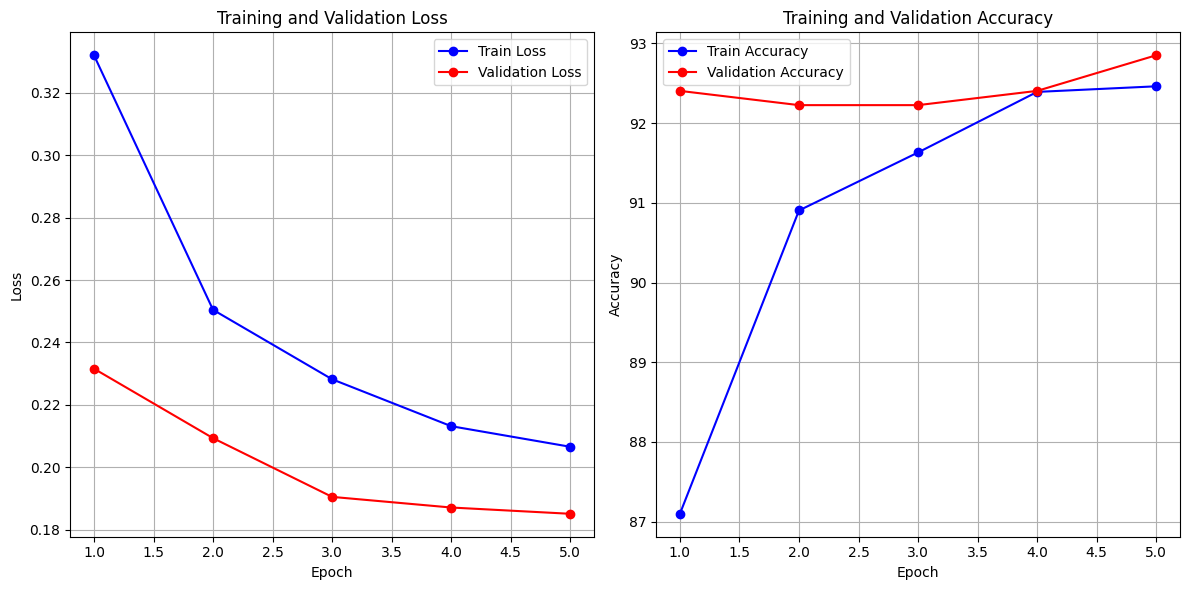

In [20]:
plot_from_history(Fsecondhistory)

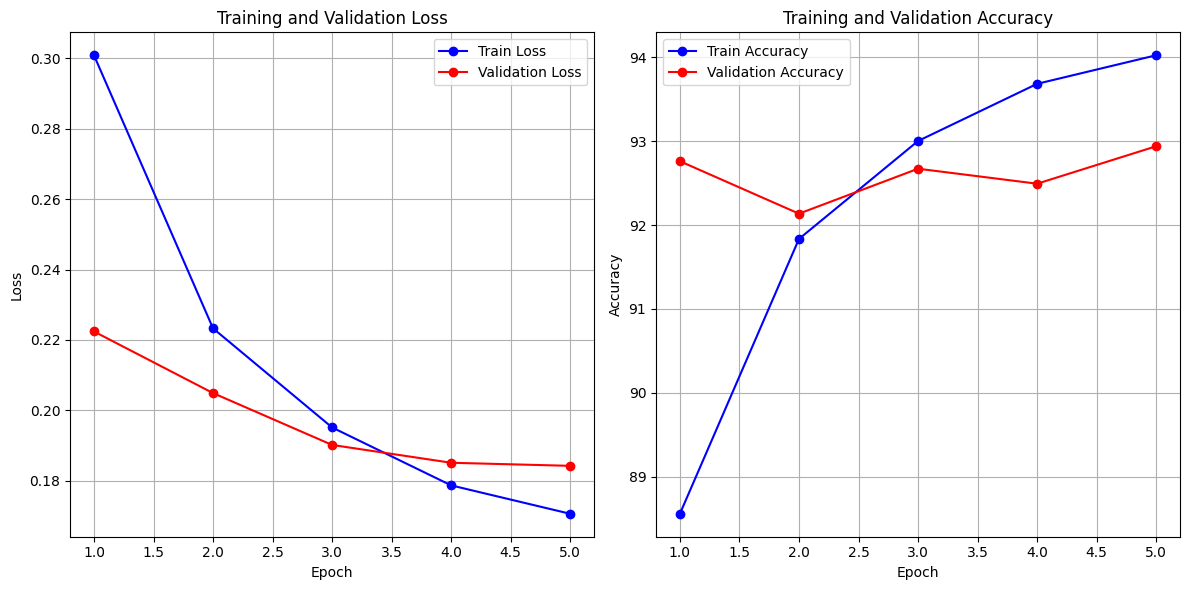

In [9]:
plot_from_history(Fsecondhistory)

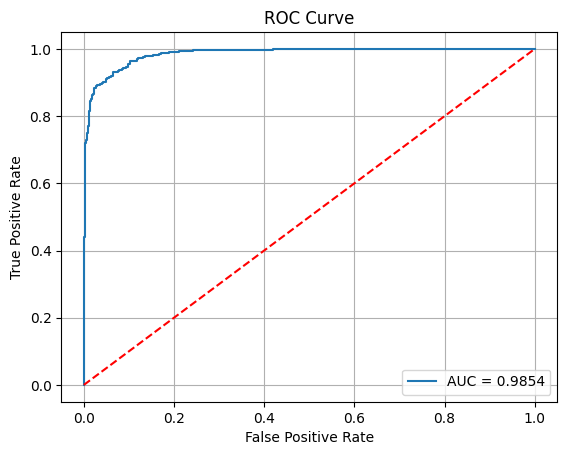

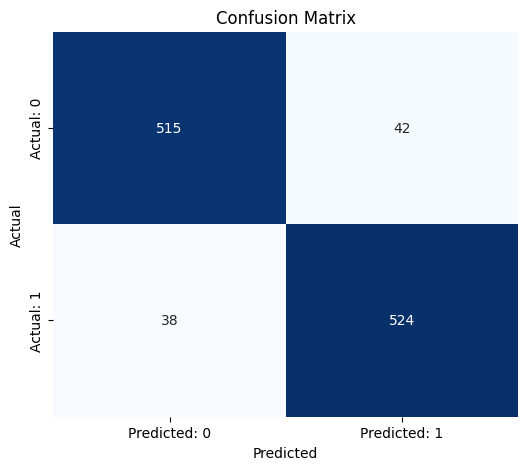

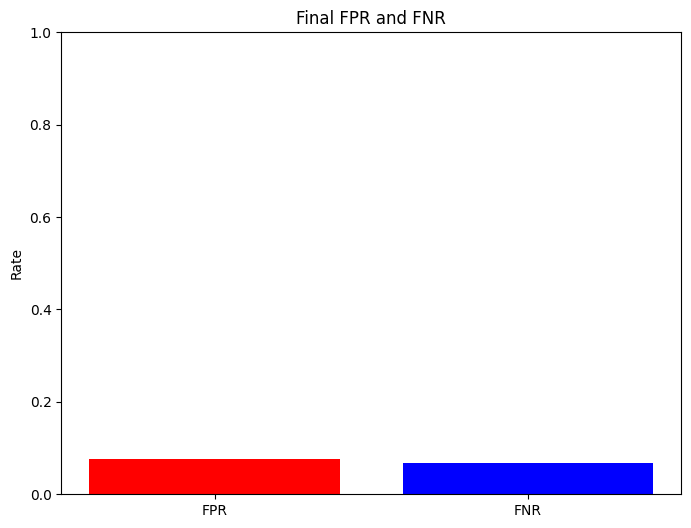

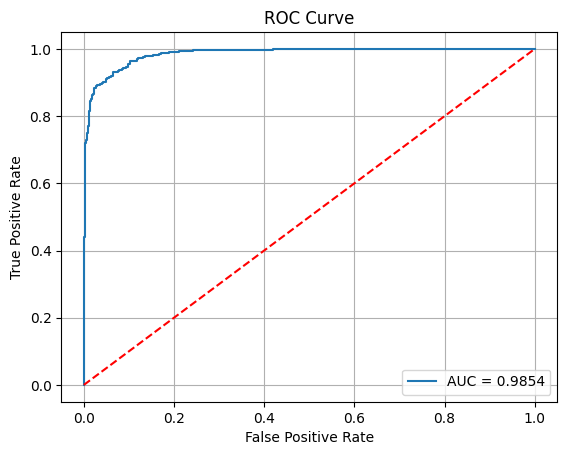

In [21]:
# Fsecondmetrics_flat = {
#     "class_names": Fsecondmetrics["class_names"],
#     "fpr": Fsecondmetrics["fpr"],
#     "fnr": Fsecondmetrics["fnr"],
#     "auc_roc": Fsecondmetrics["auc_roc"],
#     "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in Fsecondmetrics["roc_curve_fpr"]],
#     "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in Fsecondmetrics["roc_curve_tpr"]],
#     "confusion_matrix": [', '.join(map(str, cm)) for cm in Fsecondmetrics["confusion_matrix"]]
# }

Fsecondmetrics_flat = {
    "class_names": test_metrics["class_names"],
    "fpr": test_metrics["fpr"],
    "fnr": test_metrics["fnr"],
    "auc_roc": test_metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
}

plot_roc_curve(Fsecondmetrics_flat)
plot_metrics(Fsecondmetrics_flat)

### Save training results

In [22]:

with open("training_history/fixedproposed_classification_report5epochs2.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracyscore}\n") 

df = pd.DataFrame(Fsecondhistory)
df.to_csv('training_history/fixedsecond_training_history5epochs2.csv', index=False)
metrics_df = pd.DataFrame(Fsecondmetrics_flat)
metrics_df.to_csv('training_history/fixedcecond_training_metrics5epochs2.csv', index=False)



#### Read Saved Results

In [ ]:
with open("training_history/fixedproposed_classification_report5epochs.txt", "r") as file:
    report = file.read()

print(report)

history_df = pd.read_csv('training_history/fixedsecond_training_history5epochs.csv')
Fsecondhistory = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}
plot_from_history(Fsecondhistory)

metrics_df = pd.read_csv('training_history/fixedcecond_training_metrics5epochs.csv')
plot_metrics(metrics_df)

## Save Models

In [23]:
torch.save(model, "../Saved models/fixedresnet_inception_fullmodel_cropped5epochs2.pth")
scripted_model = torch.jit.script(model)  # Convert model to TorchScript
scripted_model.save("../Saved models/fixedresnet_inception_fullmodel_cropped5epochs2.pt")

#### Use saved model

In [ ]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Suppress specific UserWarning for InceptionV3
warnings.filterwarnings("ignore", message="Scripted Inception3 always returns Inception3 Tuple")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval() 

fuse = torch.jit.load("../Saved models/resnet_inception_fullmodel_cropped10epochs.pt")
fuse.to(device)
fuse.eval()

# # Perform the forward pass during prediction
# with torch.no_grad():  # Disable gradient tracking during inference for efficiency
#     x_resnet = x_resnet.to(device)  # Make sure the input is on the correct device (CPU/GPU)
#     x_inception = x_inception.to(device)
#     output = model(x_resnet, x_inception)
# # Image preprocessing functions equivalent to TensorFlow preprocessing

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Inception normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_inception = Image.open(img_path).convert('RGB')

    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    img_tensor_inception = inception_transform(img_inception).unsqueeze(0)
    
    return img_tensor_resnet, img_tensor_inception

def predict_image(img_path):
    img_tensor_resnet, img_tensor_inception = preprocess_image(img_path)
    img_tensor_resnet, img_tensor_inception = img_tensor_resnet.to(device), img_tensor_inception.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = fuse(img_tensor_resnet, img_tensor_inception)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

# BASELINE MODEL 

### Imports

In [ ]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.transforms import InterpolationMode
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from torchvision.models import ResNet50_Weights
import os
import numpy as np
from tqdm import tqdm
import glob
import pandas as pd
from torch.utils.data import DataLoader, Dataset,  Subset
from torchvision.datasets import ImageFolder
import seaborn as sns
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from Datapreprocess import AugmentedImageFolder_resnet, Applytransform_resnet
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import torch.optim as optim
from torchinfo import summary
from torch.optim import AdamW  # Import AdamW
save_dir = "./DATASETS/ECD AUGMENTED FULL"



### Data Preprocess and Splitting

In [ ]:

# dataset_path = "./train_45"
dataset_path = "./DATASETS/ECD DATASET CROPPED FULL"
if not os.path.exists(dataset_path):
    print(f"Directory not found: {dataset_path}")
else:
    print(f"Directory found: {dataset_path}")
    print("Contents:", os.listdir(dataset_path))

# Define transformations
transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
val_test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load raw dataset without transformation
dataset_raw = ImageFolder(dataset_path)
class_names = dataset_raw.classes
class_to_idx = dataset_raw.class_to_idx
print("Class Names:", class_names)

# Extract class indices
labels = [label for _, label in dataset_raw.samples]
appropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Appropriate"]]
inappropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Inappropriate"]]


# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")

# Plot original class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# # Balance dataset by undersampling the larger class
# min_class_size = min(len(appropriate_indices), len(inappropriate_indices))
# appropriate_indices = random.sample(appropriate_indices, min_class_size)
# inappropriate_indices = random.sample(inappropriate_indices, min_class_size)

# # Merge & shuffle indices
# balanced_indices = appropriate_indices + inappropriate_indices
# random.shuffle(balanced_indices)

balanced_indices = list(range(len(dataset_raw)))
balanced_indices = shuffle(balanced_indices)


# Define split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * len(balanced_indices))
val_size = int(0.15 * len(balanced_indices))
test_size = len(balanced_indices) - train_size - val_size

# Split indices
train_indices = balanced_indices[:train_size]
val_indices = balanced_indices[train_size:train_size + val_size]
test_indices = balanced_indices[train_size + val_size:]

# Create Subset datasets
dataset_train = Subset(dataset_raw, train_indices)
dataset_val = Subset(dataset_raw, val_indices)
dataset_test = Subset(dataset_raw, test_indices)

# # Wrap in AugmentedImageFolder for flipping
# dataset_train = AugmentedImageFolder_resnet(dataset_train)

# # Apply transformations to val & test sets
# dataset_val = Applytransform_resnet(dataset_val)
# dataset_test = Applytransform_resnet(dataset_test)
# # Create DataLoaders
print(f"Before Augmentation Train set size: {len(dataset_train)}")

dataset_train = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_resnet)
dataset_val = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_resnet)
dataset_test = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_resnet)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Augmented Training Dataset Size: {len(dataset_train)} (Includes Flipped Images)")
print(f"Validation Dataset Size: {len(dataset_val)}")
print(f"Test Dataset Size: {len(dataset_test)}")





### Sample images

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
from PIL import Image
from torchvision import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display original vs. augmented (flipped) images with mode check
def show_original_vs_augmented(dataset_train, dataset_raw, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        index = random.randint(0, len(dataset_train) // 2 - 1)  # Select from original images only
        original_idx = index * 2  # Original image index
        flipped_idx = original_idx + 1  # Flipped image index

        # Get original file path (before transformation)
        img_path, label_original = dataset_raw.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)
        mode_original = img_pil.mode  # Check mode

        # Load images from dataset_train (already transformed)
        img_original, label_original = dataset_train[original_idx]
        img_flipped, label_flipped = dataset_train[flipped_idx]

        # Convert tensors to numpy for display
        img_original_np = img_original.permute(1, 2, 0).numpy()
        img_flipped_np = img_flipped.permute(1, 2, 0).numpy()

        # Display original
        axes[0, i].imshow(img_original_np)
        axes[0, i].set_title(f"Original ({mode_original}) - {dataset_raw.classes[label_original]}")
        axes[0, i].axis("off")

        # Display flipped
        axes[1, i].imshow(img_flipped_np)
        axes[1, i].set_title(f"Flipped - {dataset_raw.classes[label_flipped]}")
        axes[1, i].axis("off")

    plt.suptitle("Original vs. Flipped Images from Dataset")
    plt.show()
    

# Show images using `dataset_train`
show_original_vs_augmented(dataset_train, dataset_raw)


## Model Initialization

In [ ]:

# class ResNet50Model(nn.Module):
#     def __init__(self):
#         super(ResNet50Model, self).__init__()
        
#         # Load pre-trained ResNet50 model
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
#         # Freeze all layers initially
#         for param in self.resnet.parameters():
#             param.requires_grad = False
        
#         # Replace the fully connected layer
#         self.resnet.fc = nn.Identity()
        
#         # New classification layer
#         self.batch_norm = nn.BatchNorm1d(2048)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(2048, 1)
        
#     def forward(self, x):
#         features = self.resnet(x)
#         features = self.batch_norm(features)
#         features = self.relu(features)
#         features = self.dropout(features)
#         output = torch.sigmoid(self.fc(features))
#         return output
    
    
    
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        
        # Load pre-trained ResNet50 model
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
   

        # Freeze all layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        self.resnet.fc = nn.Identity()
        # Replace the fully connected layer with a new classification layer
        self.resnet.fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        output = torch.sigmoid(self.resnet(x))
        return output


base_model_resnet = ResNet50Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model_resnet = base_model_resnet.to(device)



In [ ]:

# for param in base_model_resnet.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
for param in model.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True



### model summary

In [ ]:
torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(base_model_resnet)
summary(base_model_resnet, input_size=(1, 3, 224, 224))

# for name, param in base_model_resnet.named_parameters():
#     print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

## Plots

In [ ]:
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_metrics(metrics_df):
    # Extract individual metrics
    auc_score = metrics_df['auc_roc'][0]
    fpr = metrics_df['fpr'][0]
    fnr = metrics_df['fnr'][0]

    # Extract confusion matrix (flattened form)
    conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
    tn, fp, fn, tp = conf_matrix

    # Extract ROC curve data (flattened form)
    roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
    # Confusion Matrix heatmap
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot FPR and FNR
    plt.figure(figsize=(8, 6))
    plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
    plt.ylabel('Rate')
    plt.title('Final FPR and FNR')
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## TRAIN LOOP

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Training loop
def train_model_baseline(model, train_loader, val_loader, criterion, optimizer, epochs=5, scheduler=None, device="cuda"):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        model.train()
        for batch in progress_bar:
            x_resnet, y = batch
            x_resnet, y = x_resnet.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == y).sum().item()
            total += y.size(0)

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                x_resnet, y = batch
                x_resnet, y = x_resnet.to(device), y.to(device).float()

                outputs = model(x_resnet).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Compute Additional Metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("\nAdditional Metrics:") 
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")
        print(f"AUC-ROC Score: {auc_score:.4f}")
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        # Save Additional Metrics
        metrics["class_names"].append(["Appropriate", "Inappropriate"])
        metrics["confusion_matrix"].append(conf_matrix.ravel())
        metrics["fpr"].append(fpr)
        metrics["fnr"].append(fnr)
        metrics["auc_roc"].append(auc_score)
        metrics["roc_curve_fpr"].append(fpr_vals)
        metrics["roc_curve_tpr"].append(tpr_vals)

        model.train()  # Return model to training mode
        if scheduler:
            print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
            scheduler.step()
            print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    print("Training complete")
    return history, metrics


### Train Model

In [ ]:

# "STEADY LEARNING RATE"

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, base_model_resnet.parameters()), lr=0.0001, weight_decay=0.0001)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4)
history, metrics = train_model_baseline(base_model_resnet, train_loader, val_loader,criterion, optimizer, epochs=5, device=device )


### Model Eval Using Test Set

In [ ]:
# base_model_resnet.eval()
# y_true, y_pred, y_prob = [], [], []
    
# with torch.no_grad():
#     for x, y in test_loader:
#         x, y = x.to(device), y.to(device).float()
#         outputs = base_model_resnet(x).squeeze()
#         preds = (outputs > 0.5).cpu().int().numpy()

#         # Store ground-truth labels and predictions
#         y_true.extend(y.cpu().int().numpy())
#         y_pred.extend(preds)
#         y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
    
#     # Compute Additional Metrics for Test Set
# conf_matrix = confusion_matrix(y_true, y_pred)
# auc_score = roc_auc_score(y_true, y_prob)
# fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
# tn, fp, fn, tp = conf_matrix.ravel()
# fpr = fp / (fp + tn)
# fnr = fn / (fn + tp)
    
#  # Print Test Metrics
# print("\nTest Set Metrics:")
# print(f"False Positive Rate (FPR): {fpr:.4f}")
# print(f"False Negative Rate (FNR): {fnr:.4f}")
# print(f"AUC-ROC Score: {auc_score:.4f}")
# print(f"Confusion Matrix:\n{conf_matrix}")
# print("**Fine-Tuned Model Evaluation**")
    
# report = classification_report(y_true, y_pred)
# print(report)
# print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")
    
def evaluate_resnet_model():
    test_metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    base_model_resnet.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device).float()
            outputs = base_model_resnet(x).squeeze()
            preds = (outputs > 0.5).cpu().int().numpy()

            # Store ground-truth labels and predictions
            y_true.extend(y.cpu().int().numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC

    # Compute Additional Metrics for Test Set
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    # Print Test Metrics
    print("\nTest Set Metrics:")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("**Fine-Tuned Model Evaluation**")

    # Store metrics in dictionary
    test_metrics["class_names"].append(["Appropriate", "Inappropriate"]) 
    test_metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    test_metrics["fpr"].append(fpr)
    test_metrics["fnr"].append(fnr)
    test_metrics["auc_roc"].append(auc_score)
    test_metrics["roc_curve_fpr"].append(fpr_vals)
    test_metrics["roc_curve_tpr"].append(tpr_vals)

    # Classification Report & Accuracy
    report = classification_report(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    print(report)
    print(f"Accuracy Score: {accuracy}")

    return test_metrics, report, accuracy


test_metrics, report, accuracy = evaluate_resnet_model()

### Training results


In [ ]:
plot_from_history(history)

In [ ]:
metrics_flat = {
    "class_names": test_metrics["class_names"],
    "fpr": test_metrics["fpr"],
    "fnr": test_metrics["fnr"],
    "auc_roc": test_metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
}

# plot_roc_curve(metrics_flat)
plot_metrics(metrics_flat)

### Save training results

In [ ]:

with open("training_history/Baseline_classification_reportv11.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy}\n") 

df = pd.DataFrame(history)
df.to_csv('training_history/Baseline_training_historyv7.csv', index=False)
metrics_df = pd.DataFrame(metrics_flat)
metrics_df.to_csv('training_history/Baseline_training_metricsv7.csv', index=False)



#### Read Train Results

In [ ]:
with open("training_history/Baseline_classification_reportv11.txt", "r") as file:
    report = file.read()

print(report)

history_df = pd.read_csv('training_history/Baseline_training_historyv7.csv')
history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}
plot_from_history(history)
metrics_df = pd.read_csv('training_history/Baseline_training_metricsv7.csv')

plot_metrics(metrics_df)

##  Save Models


In [ ]:
torch.save(base_model_resnet, "../Saved models/Baseline_resnet_fullmodel_croppedv7.pth")
scripted_model = torch.jit.script(base_model_resnet)  # Convert model to TorchScript
scripted_model.save("../Saved models/Baseline_resnet_fullmodel_croppedv7.pt")

### Use saved Model

In [ ]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


base_model = torch.jit.load("../Saved models/Baseline_resnet_fullmodel_croppedv7.pt")
base_model.to(device)
base_model.eval()

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])


def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    
    return img_tensor_resnet

def predict_image(img_path):
    img_tensor_resnet = preprocess_image(img_path)
    img_tensor_resnet = img_tensor_resnet.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = base_model(img_tensor_resnet)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")